<a href="https://colab.research.google.com/github/sagyn19/nes1/blob/main/NES1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


github_url = "https://github.com/sagyn19/nes1/blob/main/fifa_players_nes1.xlsx"
url = github_url.replace("github.com", "raw.githubusercontent.com").replace("blob/", "")
df = pd.read_excel(url)


def simplify_position(pos_str):
    pos_str = pos_str.upper()
    if "GK" in pos_str:
        return "GK"
    elif any(p in pos_str for p in ["CB", "LB", "RB", "LWB", "RWB"]):
        return "D"
    elif any(p in pos_str for p in ["CM", "CDM", "CAM", "LM", "RM"]):
        return "M"
    elif any(p in pos_str for p in ["CF", "ST", "LW", "RW"]):
        return "F"
    return "Other"

df["main_position"] = df["positions"].apply(simplify_position)

# D, M, F players
df_filtered = df[df["main_position"].isin(["D", "M", "F"])].copy()


feature_columns = [
    'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
    'dribbling', 'curve', 'freekick_accuracy', 'long_passing', 'ball_control',
    'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
    'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
    'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
    'composure', 'marking', 'standing_tackle', 'sliding_tackle'
]

X = df_filtered[feature_columns].values
y = df_filtered["main_position"].map({"D": 0, "M": 1, "F": 2}).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Train labels:", np.bincount(y_train))
print("Test labels:", np.bincount(y_test))
print(df)


X_train: (362, 29)
X_test: (91, 29)
Train labels: [124 170  68]
Test labels: [31 43 17]
              name                        full_name           birth_date age  \
0         L. Messi  Lionel Andr√©s Messi Cuccittini  1987-06-24 00:00:00  31   
1       C. Eriksen     Christian  Dannemann Eriksen  1992-02-14 00:00:00  27   
2         P. Pogba                       Paul Pogba  1993-03-15 00:00:00  25   
3       L. Insigne                  Lorenzo Insigne  1991-06-04 00:00:00  27   
4     K. Koulibaly                Kalidou Koulibaly  1991-06-20 00:00:00  27   
..             ...                              ...                  ...  ..   
493       B. Butko                     Bogdan Butko  1991-01-13 00:00:00  28   
494    L. Cigarini                    Luca Cigarini  1986-06-20 00:00:00  32   
495        A. Musa                       Ahmed Musa  1992-10-14 00:00:00  26   
496    M. Morozyuk                  Mykola Morozyuk  1988-01-17 00:00:00  31   
497  G. Schennikov              

In [33]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Running Model 1 with layers [32, 16], dropout=0, batch_size=32
Test accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

    Defender       0.91      0.94      0.92        31
  Midfielder       0.85      0.81      0.83        43
     Forward       0.72      0.76      0.74        17

    accuracy                           0.85        91
   macro avg       0.83      0.84      0.83        91
weighted avg       0.85      0.85      0.85        91



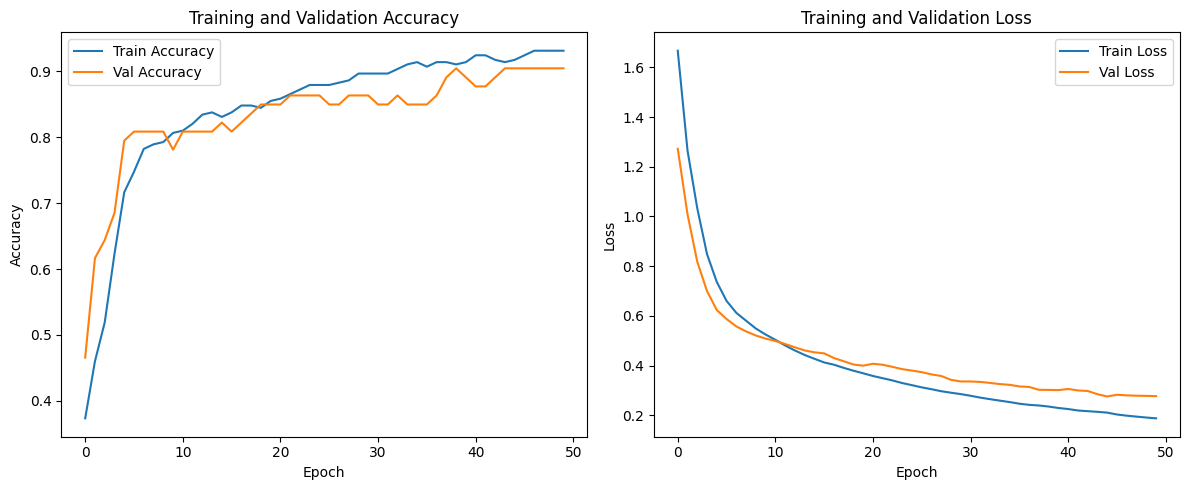

Running Model 2 with layers [32, 16], dropout=0.5, batch_size=16
Test accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

    Defender       0.97      0.97      0.97        31
  Midfielder       0.86      0.88      0.87        43
     Forward       0.75      0.71      0.73        17

    accuracy                           0.88        91
   macro avg       0.86      0.85      0.86        91
weighted avg       0.88      0.88      0.88        91



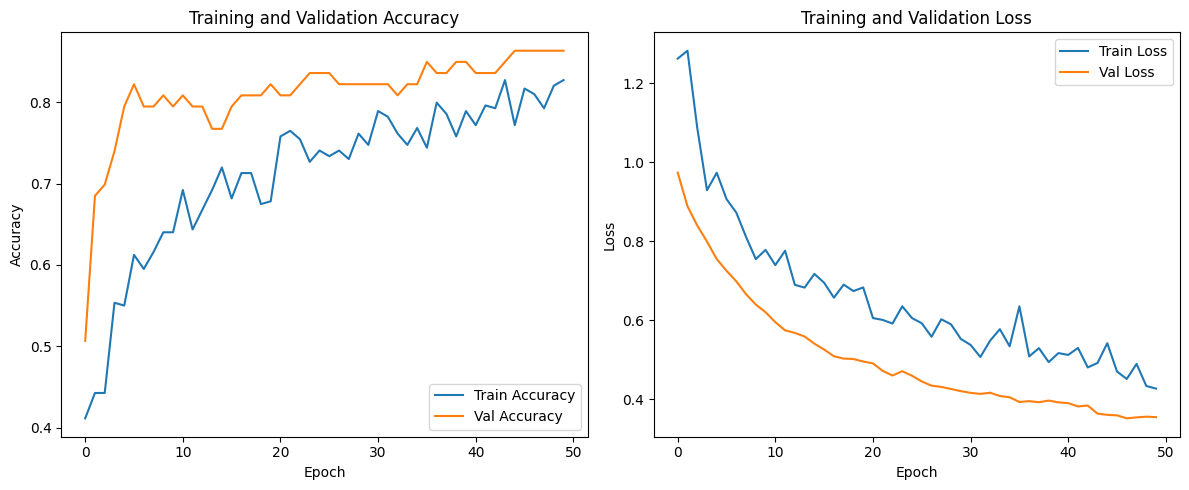

Running Model 3 with layers [64, 32], dropout=0.3, batch_size=32
Test accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

    Defender       0.97      0.90      0.93        31
  Midfielder       0.85      0.93      0.89        43
     Forward       0.87      0.76      0.81        17

    accuracy                           0.89        91
   macro avg       0.89      0.87      0.88        91
weighted avg       0.89      0.89      0.89        91



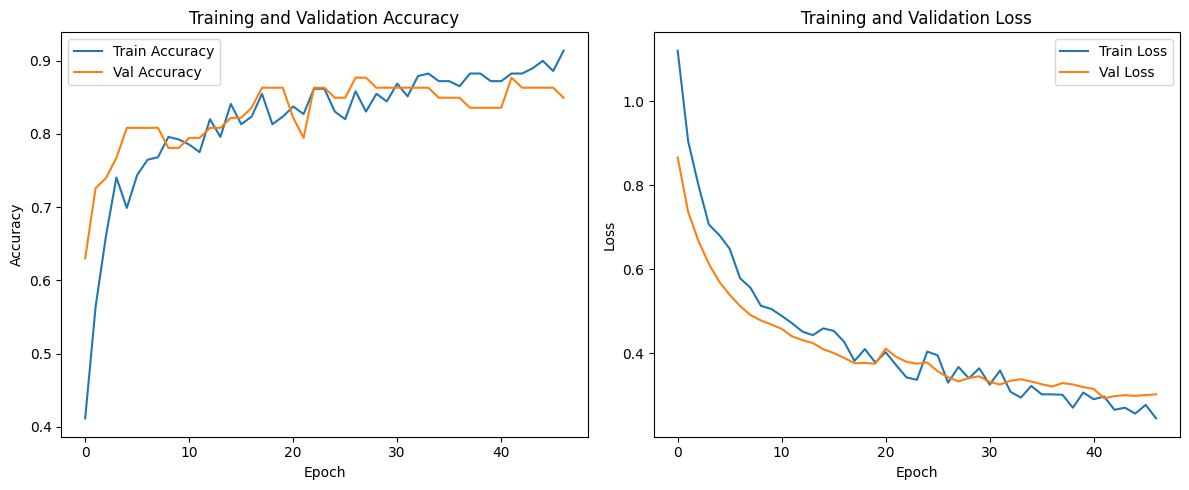

Running Model 4 with layers [128, 64], dropout=0.4, batch_size=64
Test accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

    Defender       0.97      0.94      0.95        31
  Midfielder       0.87      0.91      0.89        43
     Forward       0.81      0.76      0.79        17

    accuracy                           0.89        91
   macro avg       0.88      0.87      0.88        91
weighted avg       0.89      0.89      0.89        91



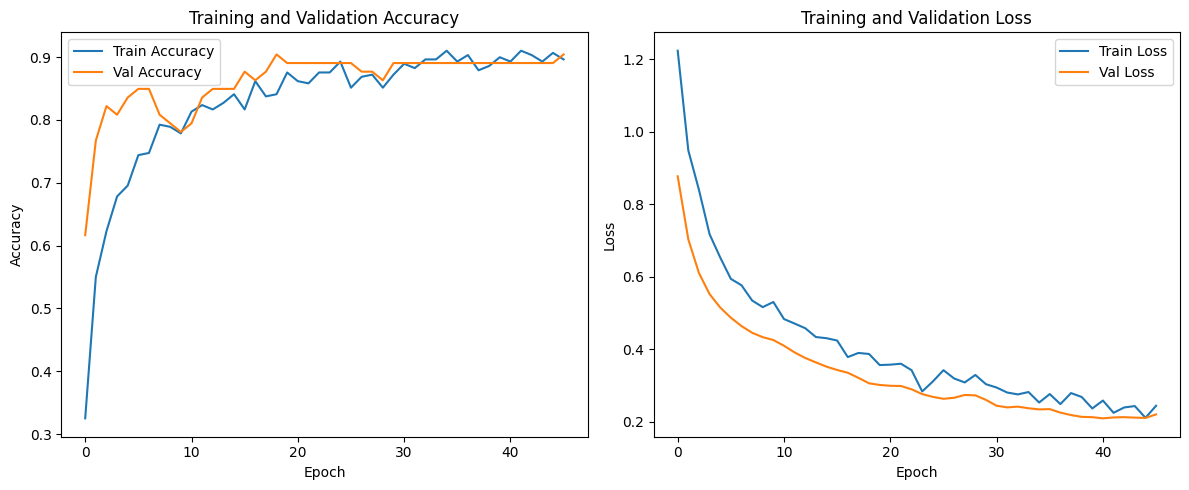

Running Model 5 with layers [64], dropout=0.2, batch_size=32
Test accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

    Defender       0.97      0.90      0.93        31
  Midfielder       0.85      0.91      0.88        43
     Forward       0.81      0.76      0.79        17

    accuracy                           0.88        91
   macro avg       0.88      0.86      0.87        91
weighted avg       0.88      0.88      0.88        91



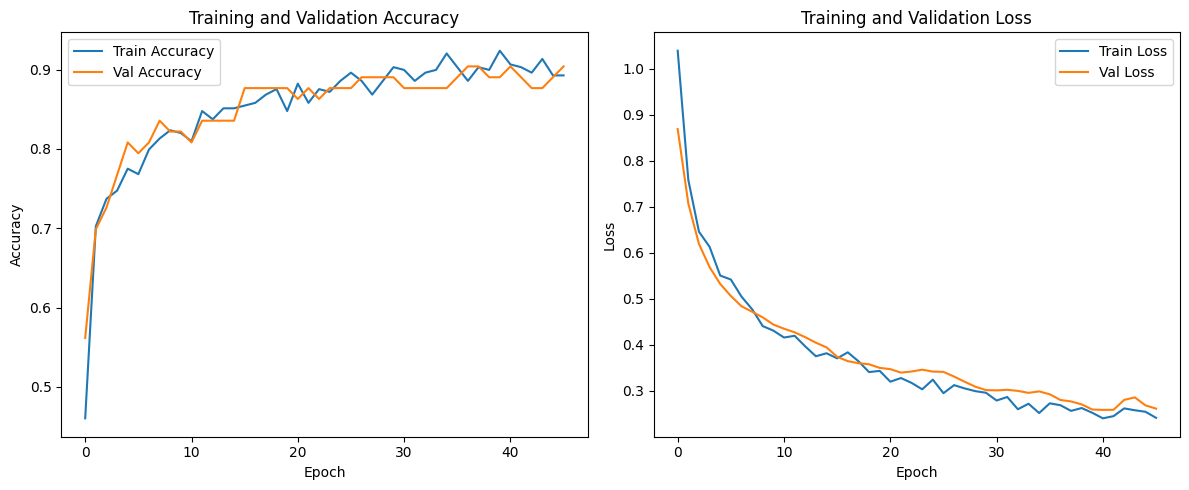

In [34]:
import numpy as np
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# List of different configurations to try
configs = [
    {"layers": [32, 16], "dropout": 0, "batch_size": 32},
    {"layers": [32, 16], "dropout": 0.5, "batch_size": 16},
    {"layers": [64, 32], "dropout": 0.3, "batch_size": 32},
    {"layers": [128, 64], "dropout": 0.4, "batch_size": 64},
    {"layers": [64], "dropout": 0.2, "batch_size": 32}
]

for i, config in enumerate(configs, 1):
    print(f"Running Model {i} with layers {config['layers']}, dropout={config['dropout']}, batch_size={config['batch_size']}")

    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    for neurons in config["layers"]:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(config["dropout"]))

    model.add(Dense(3, activation='softmax'))  # Output layer

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=config["batch_size"],
        verbose=0,
        callbacks=[early_stop]
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.2f}")

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Defender", "Midfielder", "Forward"]))
    plot_training_history(history)


              precision    recall  f1-score   support

    Defender       0.97      0.94      0.95        31
  Midfielder       0.84      0.95      0.89        43
     Forward       0.92      0.65      0.76        17

    accuracy                           0.89        91
   macro avg       0.91      0.85      0.87        91
weighted avg       0.90      0.89      0.89        91



<Axes: >

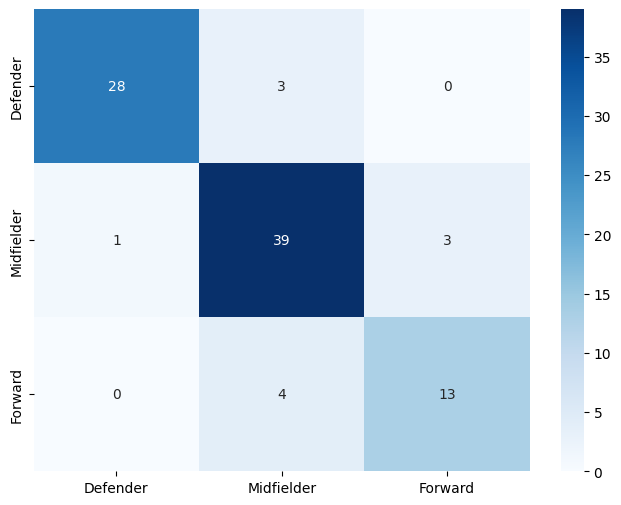

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y = df_filtered["main_position"].map({"D": 0, "M": 1, "F": 2}).values

target_names = ["Defender", "Midfielder", "Forward"]

print(classification_report(y_test, y_pred_log, target_names=target_names))


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
